<a href="https://colab.research.google.com/github/Dinaabdalla2018/Covid-19-Detection-using-AI/blob/main/Coughvid_CNN_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from keras import Sequential,Model      
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import IPython.display as ipd
import pylab
from sklearn.model_selection import train_test_split
import os
import cv2
import json
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [ ]:
# Download coughvid data in CDF format
# Run once 
!git clone "https://github.com/virufy/virufy-cdf-coughvid.git"

Cloning into 'virufy-cdf-coughvid'...
remote: Enumerating objects: 22051, done.
remote: Total 22051 (delta 0), reused 0 (delta 0), pack-reused 22051
Receiving objects: 100% (22051/22051), 1006.41 MiB | 31.22 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (22045/22045), done.


In [ ]:
%cd virufy-cdf-coughvid

/content/virufy-cdf-coughvid


In [ ]:
coughvid = pd.read_csv("virufy-cdf-coughvid.csv")
msk = (coughvid.loc[:,'cough_detected'] > 0.7)
coughvid = coughvid.loc[msk,:]

In [ ]:
# Filtering cough_detected to > .7 is advisable
# The .7 threshold can be tuned as part of model development, we recommend testing different thresholds after a model has been completed
coughvid.head()

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
0,0,coughvid,ae029647-ddc3-47f5-904e-813358c9dda3,0.8929,virufy-cdf-coughvid/ae029647-ddc3-47f5-904e-81...,NaN,NaN,NaN,2020-10-20T11:05:04.501905+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False
5,5,coughvid,3449851d-799e-404e-b143-58e852332948,0.9825,virufy-cdf-coughvid/3449851d-799e-404e-b143-58...,47.0,male,male,2020-04-14T19:39:05.755132+00:00,NaN,NaN,False,False,untested,negative,False
6,6,coughvid,0c35e382-31cd-42cb-bc87-8a84b9c52a41,1.0000,virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a...,27.0,female,female,2020-04-13T09:11:44.729740+00:00,NaN,NaN,False,False,positive,positive,NaN
9,9,coughvid,3ee8bfb5-a1d4-46c6-9b1c-3052af9bdedf,0.9943,virufy-cdf-coughvid/3ee8bfb5-a1d4-46c6-9b1c-30...,NaN,NaN,NaN,2020-04-12T20:09:17.098213+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN


In [ ]:
# Disclaimer: we have inferred some of these pcr_test_result labels based on other columns
# Target = pcr_test_result_inferred
# Positive, negative, untested

coughvid['pcr_test_result_inferred'].head(30)

0     untested
4     negative
5     negative
6     positive
9     untested
12    negative
13    untested
14    negative
15    negative
16    untested
17    untested
18    untested
20    negative
21    negative
22    negative
24    negative
25    negative
26    negative
28    negative
31    untested
33    untested
34    untested
35    negative
39    negative
40    untested
41    untested
42    untested
44    untested
45    negative
46    negative
Name: pcr_test_result_inferred, dtype: object

In [ ]:
# Filter out untested results
msk = (coughvid.loc[:,'pcr_test_result_inferred']=='untested')
coughvid = coughvid.loc[~msk,:]
coughvid

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False
5,5,coughvid,3449851d-799e-404e-b143-58e852332948,0.9825,virufy-cdf-coughvid/3449851d-799e-404e-b143-58...,47.0,male,male,2020-04-14T19:39:05.755132+00:00,NaN,NaN,False,False,untested,negative,False
6,6,coughvid,0c35e382-31cd-42cb-bc87-8a84b9c52a41,1.0000,virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a...,27.0,female,female,2020-04-13T09:11:44.729740+00:00,NaN,NaN,False,False,positive,positive,NaN
12,12,coughvid,cdd18865-400a-448e-902b-c8b53644a1c8,0.9881,virufy-cdf-coughvid/cdd18865-400a-448e-902b-c8...,24.0,male,male,2020-11-28T20:14:22.235183+00:00,NaN,NaN,False,False,untested,negative,False
14,14,coughvid,0e35f667-974e-4ffc-b596-1b9a94793d1b,0.9658,virufy-cdf-coughvid/0e35f667-974e-4ffc-b596-1b...,18.0,male,male,2020-04-14T10:52:04.775637+00:00,NaN,NaN,False,False,untested,negative,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22013,22013,coughvid,2986534b-37ef-408b-b6ec-b107225d7e8b,0.9865,virufy-cdf-coughvid/2986534b-37ef-408b-b6ec-b1...,58.0,male,male,2020-11-24T13:24:35.904905+00:00,NaN,NaN,False,False,untested,negative,False
22021,22021,coughvid,8e53179c-cff5-4dff-bec8-a78e38f79b67,0.9891,virufy-cdf-coughvid/8e53179c-cff5-4dff-bec8-a7...,16.0,male,male,2020-11-09T13:04:10.570155+00:00,NaN,NaN,False,False,untested,negative,False
22026,22026,coughvid,f9a73dc7-95c6-4e96-9f48-e9d3d9db818b,0.9918,virufy-cdf-coughvid/f9a73dc7-95c6-4e96-9f48-e9...,33.0,male,male,2020-07-10T06:30:49.755996+00:00,NaN,NaN,False,False,untested,negative,False
22029,22029,coughvid,ccc3b8b2-8c07-4aaa-adad-f8304402ecc1,0.9890,virufy-cdf-coughvid/ccc3b8b2-8c07-4aaa-adad-f8...,24.0,male,male,2020-04-09T22:52:43.174014+00:00,NaN,NaN,False,False,untested,negative,False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imgpaths=[]
diagnoses=[]
for row in tqdm(coughvid.values):
  imgpaths.append('/content/drive/MyDrive/custom_dataset/'+row[2]+'.png')
  diagnoses.append([int(row[11]),int(row[12])])

100%|██████████| 7766/7766 [00:00<00:00, 421443.74it/s]


In [ ]:
coughvid.values[2][4]

'virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a84b9c52a41.webm'

In [ ]:
coughvid = coughvid.rename(columns={'pcr_test_result_inferred': 'STATUS'})

In [ ]:
label  = lambda x: 1 if x == 'positive' else 0
data_y = list(map(label,coughvid['STATUS']))
data_xx= [imgpaths[i] for i in range(len(imgpaths))]
data_xp= [diagnoses[i]for i in range(len(diagnoses))]
data_y = [data_y[i] for i in range(len(diagnoses))]

In [ ]:
indices = np.arange(len(data_xx))
NUM_shuf= 5
DATA    = {0:{}}

DATA[0]['MEL']   = [data_xx[i] for i in indices]
DATA[0]['EXTRA'] = np.array([data_xp[i] for i in indices])
DATA[0]['LABELS']= np.array([data_y[i] for i in indices])

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale
    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        try:
          img   = cv2.imread(self.imgfiles[ID])
          img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
          X[i,] = img / self.scale
        except :
          pass

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)

    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))

    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)
    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch




In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [ ]:
def build_model():
  # Create CNN model

  x0 = Input(shape=(224, 224, 3))
  x = Conv2D(32, 3, strides=2, padding='same', activation='relu')(x0)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(2, activation='softmax')(x)

  model = Model(inputs=x0, outputs=x)

  return model

In [ ]:
MModel= build_model()
# Compile model
MModel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)


timgs     = DATA[0]['MEL'][:int(0.8*len(data_xx))]
labels    = DATA[0]['LABELS'][:int(0.8*len(data_y))]

test_imgs    = DATA[0]['MEL'][ int(0.8*len(data_xx)): int(0.9*len(data_xx))]
test_labels  = DATA[0]['LABELS'][ int(0.8*len(data_xx)): int(0.9*len(data_xx))]
                                        
val_imgs    = DATA[0]['MEL'][ int(0.9*len(data_xx)) :]
val_labels  = DATA[0]['LABELS'][ int(0.9*len(data_xx)) :]

imgs_em     = CustomDataset (timgs, labels, batch_size=48,target_size=(224,224))
TEST        = CustomDataset(test_imgs,test_labels,batch_size=48,target_size=(224,224))
VAL         = CustomDataset(val_imgs,val_labels,batch_size=48,target_size=(224,224))

checkpointer = keras.callbacks.ModelCheckpoint(filepath=("model.hdf5"),mode='max',save_best_only=False)

# Train model for 10 epochs, capture the history
history = MModel.fit(imgs_em, epochs=10, validation_data=VAL,callbacks=[checkpointer])

Epoch 1/10
129/129 [==============================] - 51s 380ms/step - loss: 0.4601 - accuracy: 0.8238 - val_loss: 0.4253 - val_accuracy: 0.8958
Epoch 2/10
129/129 [==============================] - 49s 377ms/step - loss: 0.2907 - accuracy: 0.9205 - val_loss: 0.6687 - val_accuracy: 0.6237
Epoch 3/10
129/129 [==============================] - 49s 376ms/step - loss: 0.2774 - accuracy: 0.9218 - val_loss: 0.3461 - val_accuracy: 0.9115
Epoch 4/10
129/129 [==============================] - 48s 375ms/step - loss: 0.2626 - accuracy: 0.9233 - val_loss: 0.3061 - val_accuracy: 0.9089
Epoch 5/10
129/129 [==============================] - 48s 374ms/step - loss: 0.2425 - accuracy: 0.9247 - val_loss: 0.3090 - val_accuracy: 0.9062
Epoch 6/10
129/129 [==============================] - 48s 373ms/step - loss: 0.2005 - accuracy: 0.9330 - val_loss: 1.5815 - val_accuracy: 0.1393
Epoch 7/10
129/129 [==============================] - 49s 377ms/step - loss: 0.1568 - accuracy: 0.9443 - val_loss: 1.3635 - val_ac

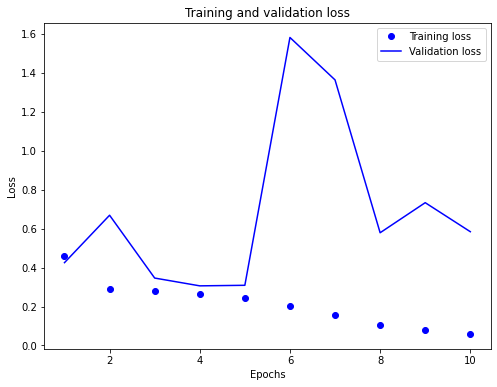

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

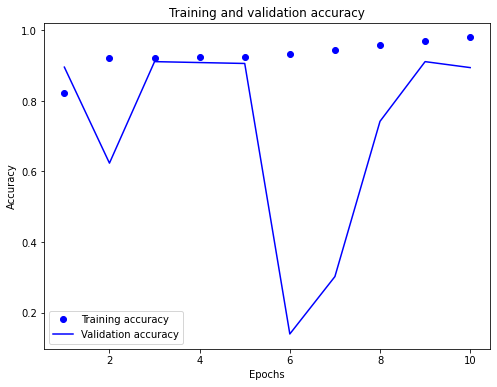

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
final_loss, final_acc = MModel.evaluate(TEST, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.514296, final accuracy: 0.906250


In [ ]:
test_imgs

['/content/drive/MyDrive/custom_dataset/b8cbfa94-3328-44f4-b1f4-e7a99613fb4b.png',
 '/content/drive/MyDrive/custom_dataset/6c0c53cf-467a-4f4f-a26a-d8b1e839a801.png',
 '/content/drive/MyDrive/custom_dataset/d55807ab-91fc-436d-b754-0eba7fb7f702.png',
 '/content/drive/MyDrive/custom_dataset/26ce1218-1d55-4f45-a0f5-643c0f92c2c2.png',
 '/content/drive/MyDrive/custom_dataset/5cd11036-516e-4d97-9c71-f6a04380fa71.png',
 '/content/drive/MyDrive/custom_dataset/bbce40e6-3523-4159-b844-fce6c1790126.png',
 '/content/drive/MyDrive/custom_dataset/cb6156a2-e9e0-4543-8cd8-8ab2d6a97bab.png',
 '/content/drive/MyDrive/custom_dataset/6922ada2-531e-47ac-841e-eb4fa86cf99d.png',
 '/content/drive/MyDrive/custom_dataset/8cdd0367-1661-4524-830d-2bd69aa6dee7.png',
 '/content/drive/MyDrive/custom_dataset/7a94b3ae-2fd8-48f3-b15d-34c157c21e8f.png',
 '/content/drive/MyDrive/custom_dataset/c85b3e99-29fa-4331-a5c3-f7258baec02b.png',
 '/content/drive/MyDrive/custom_dataset/14e0f55e-4cb8-4d94-b333-7491ed738e51.png',
 '/c

# Demo Function

In [ ]:
def check_my_cough(aduio_path):
  '''
  1. Load the aduio
  2. Convert the aduio to MEL image
  3. Prepare the input od the model
  4. Make prediction
  '''

  # load aduio
  audio,sr = librosa.load(aduio_path)
  
  #Mel Spectogram
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
  melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
  s_db     = librosa.power_to_db(melspec, ref=np.max)
  librosa.display.specshow(s_db)

  savepath = os.path.join('/content/out.png')
  pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
  pylab.close()

  # Model preperation
  input_img = cv2.imread(savepath)
  input_img.resize((224,224,3))
  input_img = input_img.reshape((1,224,224,3))

  # Get prediction
  prediction = MModel.predict(input_img).argmax()
  label_dict = { 0 : 'NO COVID' ,  1: 'COVID'}
  # display audio 
  return label_dict[prediction]


In [ ]:
from IPython.display import Audio 
from IPython.core.display import display
aduio_path = 'virufy-cdf-coughvid/0e35f667-974e-4ffc-b596-1b9a94793d1b.webm'
display(Audio(aduio_path))
print(check_my_cough(aduio_path))
aduio_path1 = 'virufy-cdf-coughvid/b8cbfa94-3328-44f4-b1f4-e7a99613fb4b.webm'
display(Audio(aduio_path1))
print(check_my_cough(aduio_path1))

NO COVID


COVID


In [ ]:
import numpy as np
x = np.array([1,0,1])

In [ ]:
print(x)

[1 0 1]
